# Setup

## Packages

In [0]:
# Utils
import numpy as np
from pdb import set_trace
from PIL import Image


# NN
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.distributions import Categorical
import gym


## Constants

In [0]:
BETA = .2
LAMBDA = .1
DISCOUNT_FACTOR = 0.99
LR = 1e-3

NUM_EPOCH = 200
NUM_STEP = 3000

# Models

## ConvBlock

In [0]:
class ConvBlock(nn.Module):
    """ 4 Conv2d + LeakyReLU """
    def __init__(self, ch_in=1):
        super(ConvBlock, self).__init__()
        
        # constants
        self.num_filter = 32
        self.size = 3
        self.stride = 2
        self.pad = self.size//2 

        # layers
        self.conv1 = nn.Conv2d(ch_in, self.num_filter, self.size, self.stride, self.pad)
        self.conv2 = nn.Conv2d(self.num_filter, self.num_filter, self.size, self.stride, self.pad)
        self.conv3 = nn.Conv2d(self.num_filter, self.num_filter, self.size, self.stride, self.pad)
        self.conv4 = nn.Conv2d(self.num_filter, self.num_filter, self.size, self.stride, self.pad)

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = F.leaky_relu(self.conv4(x))

        return torch.flatten(x)

## FeatureEncoderNet

In [0]:
class FeatureEncoderNet(nn.Module):
    """ Network for feature encoding

        In: [s_t]
            Current state (i.e. pixels) -> 1 channel image is needed

        Out: phi(s_t)
            Current state transformed into feature space

    """
    def __init__(self, in_size, is_a3c=True):
        super(FeatureEncoderNet, self).__init__()
        # constants
        self.in_size = in_size
        self.h1 = 256
        self.is_a3c = is_a3c # indicates whether the LSTM is needed

        # layers
        self.conv = ConvBlock()
        if self.is_a3c:
          self.lstm = nn.LSTMCell(input_size=self.in_size, hidden_size=self.h1)

          
    def reset_lstm(self, x):
      if self.is_a3c:
          with torch.no_grad():
            self.h_t1 = self.c_t1 = torch.zeros(x, self.h1).cuda() if torch.cuda.is_available() else torch.zeros(x,self.h1)

    def forward(self, x):
        x = self.conv(x)
        
        if self.is_a3c:
          from pdb import set_trace
          #set_trace()
          
          x = x.view(-1, self.in_size)
          
          self.h_t1, self.c_t1 = self.lstm(x, (self.h_t1, self.c_t1)) # h_t1 is the output

          return self.h_t1#[:, -1, :]#.reshape(-1)
        
        else:
          return x.view(-1, self.in_size)

## InverseNet

In [0]:
class InverseNet(nn.Module):
    """ Network for the inverse dynamics

        In: torch.cat((phi(s_t), phi(s_{t+1}), 1)
            Current and next states transformed into the feature space, 
            denoted by phi().

        Out: \hat{a}_t
            Predicted action

    """
    def __init__(self, num_actions):
        super(InverseNet, self).__init__()

        # constants
        #self.conv_out = 288
        self.feat_size = 288
        self.fc_hidden = 256
        self.num_actions = num_actions

        # layers
        #self.conv = ConvBlock()
        self.fc1 = nn.Linear(self.feat_size*2, self.fc_hidden)
        self.fc2 = nn.Linear(self.fc_hidden, self.num_actions)

    def forward(self, x):
        return self.fc2(self.fc1(x))

## ForwardNet

In [0]:
class ForwardNet(nn.Module):
    """ Network for the forward dynamics

    In: torch.cat((phi(s_t), a_t), 1)
        Current state transformed into the feature space, 
        denoted by phi() and current action

    Out: \hat{phi(s_{t+1})}
        Predicted next state (in feature space)

    """
    def __init__(self, in_size):

        super(ForwardNet, self).__init__()

        # constants
        self.in_size = in_size
        self.fc_hidden = 256
        self.out_size = 288

        # layers
        self.fc1 = nn.Linear(self.in_size, self.fc_hidden)
        self.fc2 = nn.Linear(self.fc_hidden, self.out_size)

    def forward(self, x):
        #set_trace()
        return self.fc2(self.fc1(x))

## AdversarialHead

In [0]:
class AdversarialHead(nn.Module):
    def __init__(self, feat_size, num_actions):
        super(AdversarialHead, self).__init__()

        # constants
        self.feat_size = feat_size
        self.num_actions = num_actions

        # networks
        self.fwd_net = ForwardNet(self.feat_size + self.num_actions)
        self.inv_net = InverseNet(num_actions)

    def forward(self, phi_t, phi_t1, a_t):
        """
            phi_t: current encoded state
            phi_t1: next encoded state

            a_t: current action
        """

        # forward dynamics
        # predict next encoded state
        fwd_in = torch.cat((phi_t, a_t), 1) # concatenate next to each other
        phi_t1_hat =  self.fwd_net(fwd_in)

        # inverse dynamics
        # predict the action between s_t and s_t1
        inv_in = torch.cat((phi_t, phi_t1), 1)
        a_t_hat = self.inv_net(inv_in)


        return phi_t1_hat, a_t_hat

## ICMNet

In [0]:
class ICMNet(nn.Module):
    def __init__(self, num_actions, in_size=288, feat_size=256):
        super(ICMNet, self).__init__()

        # constants
        self.in_size = in_size # pixels i.e. state
        self.feat_size = feat_size
        self.num_actions = num_actions

        # networks
        self.feat_enc_net = FeatureEncoderNet(self.in_size, is_a3c=False)
        self.pred_net = AdversarialHead(self.in_size, self.num_actions)     # goal: minimize prediction error 
        self.policy_net = AdversarialHead(self.in_size, self.num_actions)   # goal: maximize prediction error 
                                                                            # (i.e. predict states which can contain new information)

    def forward(self, s_t, s_t1, a_t):
        """
            s_t : current state
            s_t1: next state

            phi_t: current encoded state
            phi_t1: next encoded state

            a_t: current action
        """

        # encode the states
        
        phi_t = self.feat_enc_net(s_t)
        phi_t1 = self.feat_enc_net(s_t1)
        #set_trace()

        # HERE COMES THE NEW THING (currently commented out)
        phi_t1_pred, a_t_pred = self.pred_net(phi_t, phi_t1, a_t)
        #phi_t1_policy, a_t_policy = self.policy_net_net(phi_t, phi_t1, a_t)


        return phi_t1, phi_t1_pred, a_t_pred#(phi_t1_pred, a_t_pred), (phi_t1_policy, a_t_policy)

## A3CNet

In [0]:
class A3CNet(nn.Module):
    def __init__(self, num_actions, in_size=288):
        super(A3CNet, self).__init__()

        # constants
        self.in_size = in_size
        self.num_actions = num_actions

        # networks
        self.feat_enc_net = FeatureEncoderNet(self.in_size)
        self.actor = nn.Linear(self.feat_enc_net.h1, self.num_actions) # estimates what to do
        self.critic = nn.Linear(self.feat_enc_net.h1, 1) # estimates how good the value function (how good the current state is)

    def forward(self, s_t):
        """
            s_t : current state
           
            phi_t: current encoded state
        """
        phi_t = self.feat_enc_net(s_t)

        policy = self.actor(phi_t)
        value = self.critic(phi_t)

        return policy, torch.squeeze(value)

# Agent

In [0]:
class ICMAgent(nn.Module):
    def __init__(self, env_name, num_epoch, num_steps,
                 discount_factor=DISCOUNT_FACTOR, in_size=288):
        super().__init__()

        # constants
        self.in_size = in_size
        self.is_cuda = torch.cuda.is_available()
        self.env = gym.make(env_name)
        self.num_actions = self.env.action_space.n
        self.num_epoch = num_epoch
        self.num_steps = num_steps
        self.discount_factor = discount_factor
        
        self.cum_r = 0
        
        # logging
        self.clear_log_lists()
       

        # networks
        self.icm = ICMNet(self.num_actions, self.in_size)
        self.a3c = A3CNet(self.num_actions, self.in_size)

        if self.is_cuda:
            self.icm.cuda()
            self.a3c.cuda()

        # optimizer
        self.optimizer = optim.Adam( list(self.icm.parameters()) + list(self.a3c.parameters()) )
        
    def clear_log_lists(self):
        self.r_l = []
        self.s_t_l = []
        self.s_t1_l = []
        self.a_t_l = []
        self.a_t_log_prob_l = []
        self.a_t1_l = []
        self.policy_l = []
        self.value_l = []
        
                

        
    def get_action(self, s_t):
        policy, value = self.a3c(s_t) # use A3C to get policy and value
        action_prob = F.softmax(policy, dim=-1)#.data.cpu().numpy()
        #action_prob = action_prob[0,:,:] #remove first dimension
        cat = Categorical(action_prob)
        a_t = cat.sample() # detach for action?
        
        # append current action, policy and value
        self.a_t_l.append(a_t)
        self.a_t_log_prob_l.append(cat.log_prob(a_t))
        self.policy_l.append(policy)
        self.value_l.append(value)
        

        from pdb import set_trace
        #set_trace()
        return a_t#, value, policy#.detach()


    # functions
    def pix2tensor(self, pix):
        im2tensor = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Grayscale(1),
                                        transforms.Resize((42,42)),
                                        transforms.ToTensor()])

        return im2tensor(pix).cuda()
      
    def play(self):
        """
            s_t : current state
            s_t1: next state

            phi_t: current encoded state
            phi_t1: next encoded state

            a_t: current action
        """
                
        # reset all logger lists
        self.clear_log_lists()
        
        self.a3c.feat_enc_net.reset_lstm(1)

        # play one game
        s_t  = self.env.reset()
        self.s_t_l.append(self.pix2tensor(s_t)) # append current state

        for step in range(self.num_steps):
            a_t = self.get_action(torch.unsqueeze(self.s_t_l[-1],0)) # select action from the policy
            
            # interact with the environment
            s_t, r, done, info = self.env.step(a_t)
            s_t = self.pix2tensor(s_t)

            # append next state and reward
            self.s_t_l.append(s_t)
            self.r_l.append(r)
            
            if done:
              print("Episode finished")
              break

    def reward_update(self):
      policy_loss = []
      value_loss = []
      r_disc = []
      
      """Calculate discounted rewards"""
      R = 0 # cumulated reward
      for r in self.r_l:
        R = r + self.discount_factor * R
        r_disc.insert(0,R)
        
      r_disc = torch.tensor(r_disc).cuda() # tensorize
      r_disc = (r_disc - r_disc.mean()) / (r_disc.std() + 10e-9) # normalize
      
      return r_disc
      
      
    def a3c_loss(self):
      """returns: discounted values"""
      
      returns = self.reward_update()
      
      policy_losses = []
      value_losses = []
      
      # grab the log probability of the action taken, the value associated to it
      # and the reward
      for log_prob, value, R in zip(self.a_t_log_prob_l, self.value_l, returns):
        
        # calculate advantage
        # i.e. how good was the estimate of the value of the current state
        advantage = R - value.item()
        
        # weight the deviation of the predicted value (of the state) from the 
        # actual reward (=advantage) with the negative log probability of the action
        # taken (- needed as log(p) p in [0;1] < 0)
        policy_losses.append(-log_prob * advantage)
        
        # the value loss weights the squared difference between the actual
        # and predicted rewards
        value_losses.append(F.mse_loss(value, torch.tensor([R]).cuda()))
        
      
      # return the a3c loss
      # which is the sum of the actor (policy) and critic (advantage) losses
      
      loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
      
      return loss
        
        
      
             

    def train(self):
        """
            s_t : current state
            s_t1: next state

            phi_t: current encoded state
            phi_t1: next encoded state

            a_t: current action
        """
        pass

        for epoch in range(self.num_epoch):
          
          # play an episode
          self.play()
          
          s_t_stacked = self.s_t_l
          #s_t_stacked = [self.s_t_l[0]]*3 +  self.s_t_l
          #set_trace()
          #s_t_stacked = [torch.stack(s_t_stacked[i:i+3], 3) for i in range(0,len(s_t_stacked)-3)]
          #s_t_stacked = [i.view(i.shape[0], i.shape[1],-1) for i in s_t_stacked]
          #set_trace()
          
          s_t = torch.stack(s_t_stacked[0:-1]) # last value is not needed here
          s_t1 = torch.stack(s_t_stacked[1:])
          


          a_t = torch.FloatTensor(self.a_t_l)
          # convert the action tensor into one-hot
          a_t_1_hot = torch.zeros(a_t.shape[0],self.num_actions).scatter_(1, a_t.long().view(-1,1),1)
          
          if self.is_cuda:
            s_t = s_t.cuda()
            s_t1 = s_t1.cuda()
            a_t = a_t.cuda()
            a_t_1_hot = a_t_1_hot.cuda()
            
          
          # reset LSTM hidden states
          #self.a3c.feat_enc_net.reset_lstm(s_t.shape[0])  # specify size 
          
          
          from pdb import set_trace
          #set_trace()

          # call the ICM model         
          self.icm.feat_enc_net.reset_lstm(s_t.shape[0])
          phi_t1, phi_t1_pred, a_t_pred = self.icm(s_t, s_t1, a_t_1_hot)


          """calculate losses"""
          self.optimizer.zero_grad()
          
          # forward loss
          # discrepancy between the predicted and actual next states
          loss_forward = F.mse_loss(phi_t1_pred, phi_t1)
          
          # inverse loss
          # cross entropy between the predicted and actual actions
          loss_inv = F.cross_entropy(a_t_pred, a_t.long().view(-1))
          
          # a3c loss
          # loss of the policy (how good can we choose the proper action)
          # and the advantage function (how good is the estimate of the value 
          # of the current state)
          loss_a3c = self.a3c_loss()

          
          # compose losses
          loss = BETA * loss_forward + (1-BETA) * loss_inv + LAMBDA * loss_a3c

          loss.backward()
          self.optimizer.step()
          
          print("Epoch: {}, loss {}".format(epoch, loss) )


# Train

In [0]:


# objects
#env = gym.make('MsPacman-v0')
#env = gym.make('MontezumaRevenge-v0')
agent = ICMAgent('Pong-v0', NUM_EPOCH, NUM_STEP)

agent.cuda()
agent.train()


In [0]:
agent.train()

In [411]:
agent.train()

Episode finished
Epoch: 0, loss 61.54340362548828
Episode finished
Epoch: 1, loss 58.91178512573242
Episode finished
Epoch: 2, loss 33.65998077392578
Episode finished
Epoch: 3, loss 63.651248931884766
Episode finished
Epoch: 4, loss 133.27854919433594
Episode finished
Epoch: 5, loss 31.519001007080078
Episode finished
Epoch: 6, loss 164.44361877441406
Episode finished
Epoch: 7, loss 129.20599365234375
Episode finished
Epoch: 8, loss 192.78878784179688
Episode finished
Epoch: 9, loss 161.34274291992188
Episode finished
Epoch: 10, loss 101.743408203125
Episode finished
Epoch: 11, loss 136.18333435058594
Episode finished
Epoch: 12, loss 87.29539489746094
Episode finished
Epoch: 13, loss 113.50727081298828
Episode finished
Epoch: 14, loss 96.94348907470703
Episode finished
Epoch: 15, loss 112.46073150634766
Episode finished
Epoch: 16, loss 43.080101013183594
Episode finished
Epoch: 17, loss 105.36235046386719
Episode finished
Epoch: 18, loss 91.56072235107422
Episode finished
Epoch: 19, lo

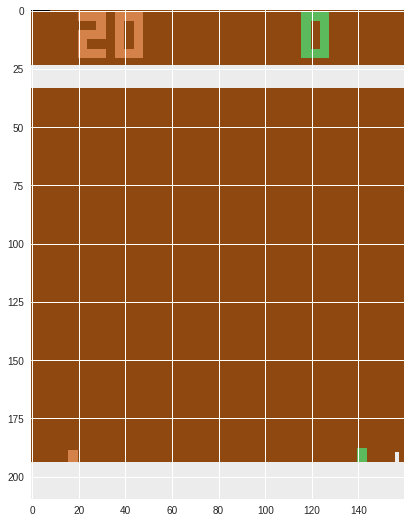

In [412]:
import gym
from IPython import display
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline


s_t = agent.env.reset()
plt.figure(figsize=(9,9))

for _ in range(2000):
    plt.imshow(agent.env.render(mode='rgb_array')) # just update the data
    #display.display(plt.gcf())    
    display.clear_output(wait=True)
    agent.get_action(torch.unsqueeze(agent.pix2tensor(s_t),0))
    s_t, r, done, info = agent.env.step(agent.a_t_l[-1])
agent.env.close()